In [9]:
# 导入环境的包
import time
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

## keras
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU
from tensorflow.keras.models import Sequential

In [10]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [11]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
daily_cases_ = pd.read_csv('../new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [13]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [26]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
train = values[400:-7, :]
test = values[-7:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(435, 1, 1) (435,) (7, 1, 1) (7,)


In [27]:
time_start = time.time()  # 记录开始时间

#网络模型
model = Sequential()
model.add(GRU(100,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("train time:",time_sum)


# 显示训练的loss值情况
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

time_start = time.time()  # 记录开始时间

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("predict time:",time_sum)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Epoch 1/100
55/55 - 3s - loss: 0.0183 - val_loss: 0.0162
Epoch 2/100
55/55 - 0s - loss: 0.0148 - val_loss: 0.0110
Epoch 3/100
55/55 - 0s - loss: 0.0142 - val_loss: 0.0095
Epoch 4/100
55/55 - 0s - loss: 0.0130 - val_loss: 0.0082
Epoch 5/100
55/55 - 0s - loss: 0.0121 - val_loss: 0.0069
Epoch 6/100
55/55 - 0s - loss: 0.0107 - val_loss: 0.0056
Epoch 7/100
55/55 - 0s - loss: 0.0091 - val_loss: 0.0043
Epoch 8/100
55/55 - 0s - loss: 0.0079 - val_loss: 0.0032
Epoch 9/100
55/55 - 0s - loss: 0.0070 - val_loss: 0.0023
Epoch 10/100
55/55 - 0s - loss: 0.0062 - val_loss: 0.0014
Epoch 11/100
55/55 - 0s - loss: 0.0059 - val_loss: 0.0010
Epoch 12/100
55/55 - 0s - loss: 0.0053 - val_loss: 6.0395e-04
Epoch 13/100
55/55 - 0s - loss: 0.0046 - val_loss: 3.3289e-04
Epoch 14/100
55/55 - 0s - loss: 0.0044 - val_loss: 2.5261e-04
Epoch 15/100
55/55 - 0s - loss: 0.0046 - val_loss: 1.4100e-04
Epoch 16/100
55/55 - 0s - loss: 0.0045 - val_loss: 1.0162e-04
Epoch 17/100
55/55 - 0s - loss: 0.0035 - val_loss: 3.5513e-05

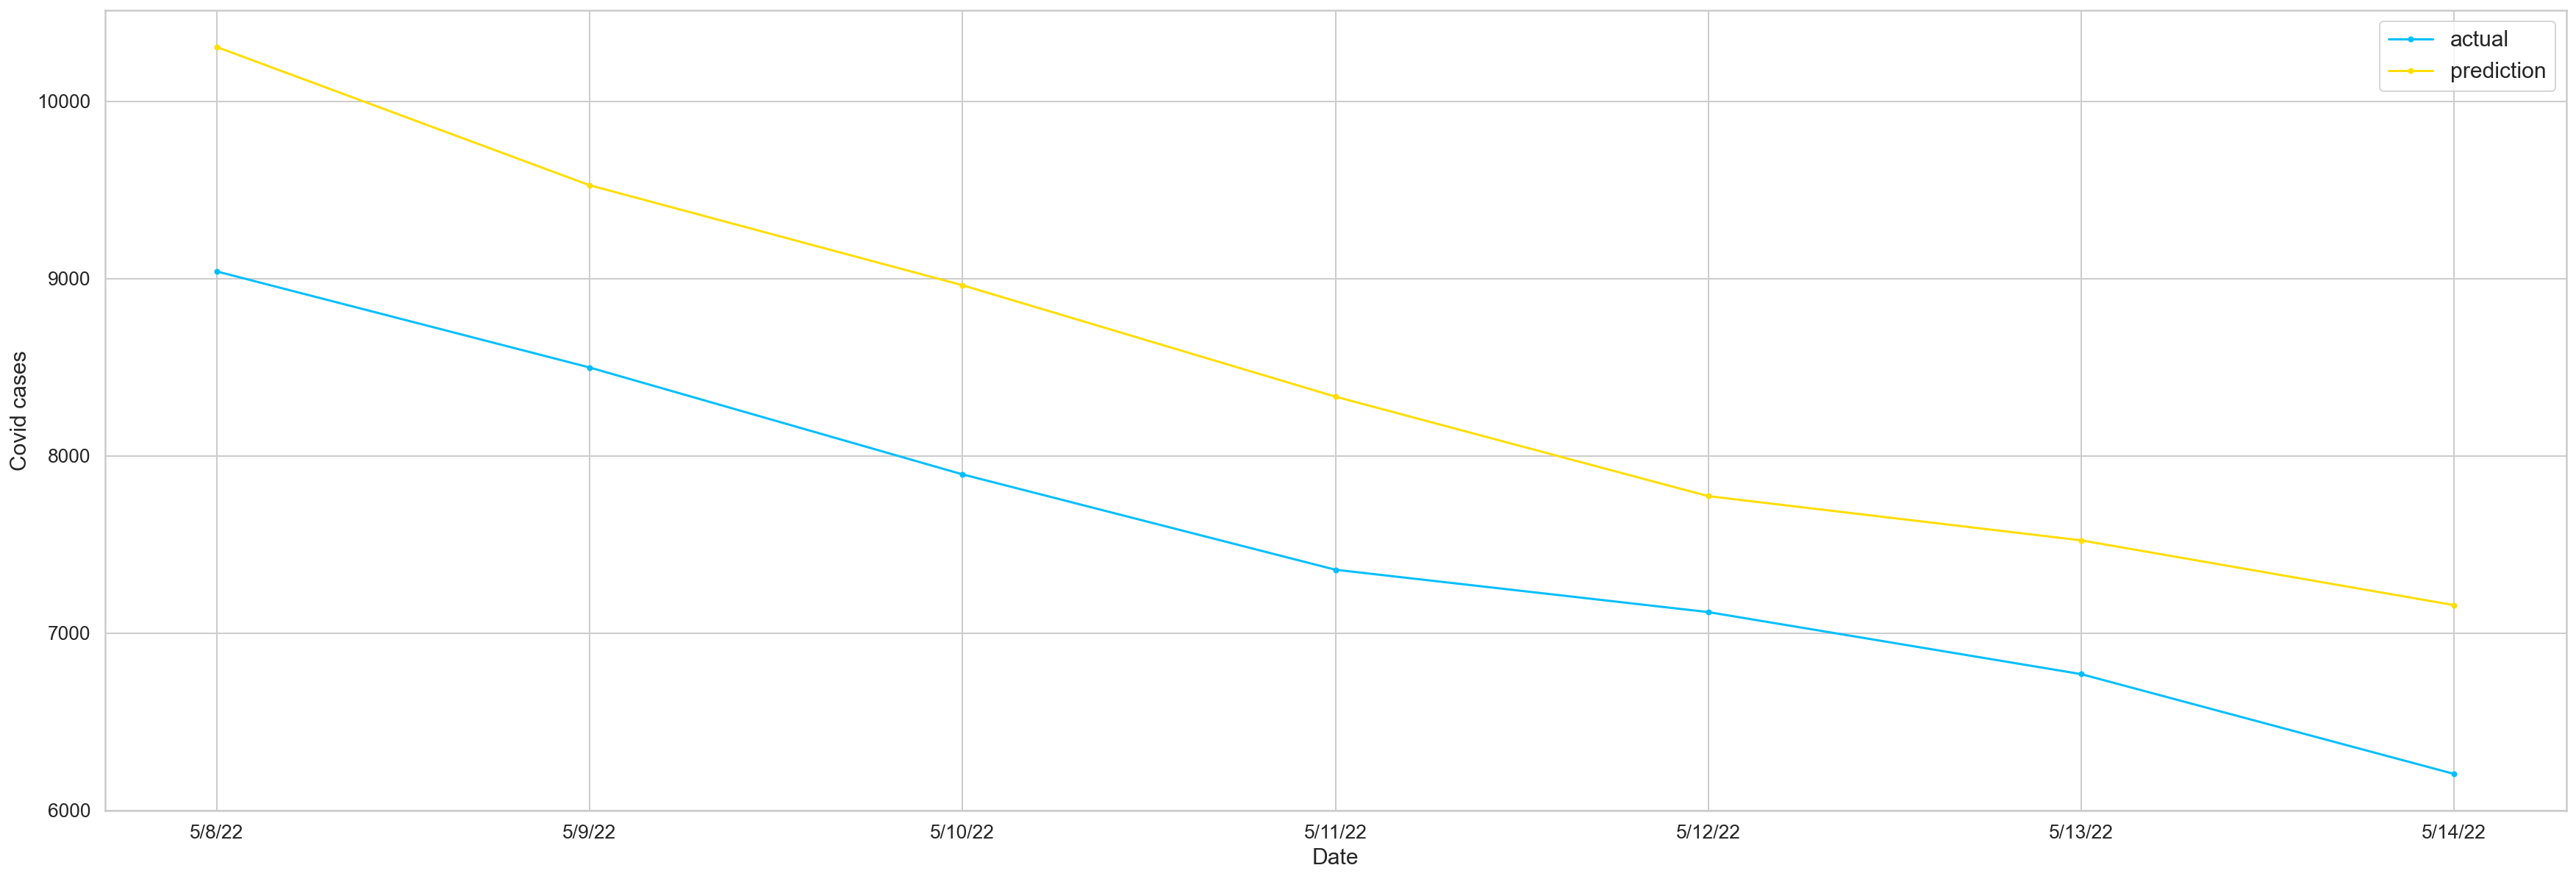

Index(['2/26/21', '2/27/21', '2/28/21', '3/1/21', '3/2/21', '3/3/21', '3/4/21',
       '3/5/21', '3/6/21', '3/7/21',
       ...
       '4/28/22', '4/29/22', '4/30/22', '5/1/22', '5/2/22', '5/3/22', '5/4/22',
       '5/5/22', '5/6/22', '5/7/22'],
      dtype='object', length=436)

In [41]:
# 显示预测结果
plt.plot(df_resample.index[-7:], inv_y[-7:], marker='.', label="actual")
plt.plot(df_resample.index[-7:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()
df_resample.index[400:-7]

In [36]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases.astype(int)

array([10306,  9526,  8961,  8333,  7772,  7522,  7157])

In [37]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[975.0921, 0.3439, 12.6671, 11.8859]

In [38]:
history.history['loss']

[0.018294252455234528,
 0.014767816290259361,
 0.014161347411572933,
 0.012959984131157398,
 0.01214214600622654,
 0.010656634345650673,
 0.009096731431782246,
 0.007944881916046143,
 0.007005443796515465,
 0.006243340205401182,
 0.0058965557254850864,
 0.005346053279936314,
 0.004585843998938799,
 0.004354253876954317,
 0.004615270532667637,
 0.004497468005865812,
 0.003462968859821558,
 0.004112245514988899,
 0.0038149121683090925,
 0.004914371762424707,
 0.004150336142629385,
 0.004152326378971338,
 0.004148977808654308,
 0.004010927863419056,
 0.0044683245941996574,
 0.0036643522325903177,
 0.004548131488263607,
 0.0031557208858430386,
 0.003758247708901763,
 0.0032793348655104637,
 0.0034000291489064693,
 0.0033394668716937304,
 0.003104046918451786,
 0.003925791475921869,
 0.004309806507080793,
 0.0034794018138200045,
 0.003372748149558902,
 0.0041034165769815445,
 0.003833209862932563,
 0.0030354431364685297,
 0.0040815467946231365,
 0.0035919786896556616,
 0.0030719067435711622

In [39]:
history.history['val_loss']

[0.01616930402815342,
 0.011034058406949043,
 0.009466933086514473,
 0.00821154098957777,
 0.006944081746041775,
 0.005637314170598984,
 0.004323586355894804,
 0.0031779292039573193,
 0.0022528173867613077,
 0.001398932421579957,
 0.001009171362966299,
 0.0006039473228156567,
 0.0003328902239445597,
 0.00025260570691898465,
 0.000141000360599719,
 0.00010161603131564334,
 3.5512617614585906e-05,
 5.417326246970333e-05,
 1.3552022210205905e-05,
 5.3088238928467035e-05,
 1.3762698472419288e-05,
 6.501361349364743e-05,
 6.654519438598072e-06,
 2.1857731553609483e-05,
 2.2916481611900963e-05,
 6.383091658790363e-06,
 2.086251879518386e-05,
 6.0786922404076904e-05,
 1.7119315089075826e-05,
 5.732672434533015e-05,
 3.56974960595835e-05,
 5.113487713970244e-05,
 6.111036782385781e-05,
 6.274755833146628e-06,
 4.633829303202219e-05,
 8.956225428846665e-06,
 1.8957392967422493e-05,
 0.00015559648454654962,
 6.69582414047909e-06,
 7.014210859779269e-05,
 3.3534968679305166e-05,
 0.00015222396177